# Energy Systems Group Assignment: RPower Plant Dispatch
#### Tobias Benedikt Blenk, Darlene Sonal D'Mello, Adnan Moiz, Diep Hang Stefanie Ngoc Nguyen ####

Import necessary packages

In [109]:
import pyomo.environ as pyo
import pandas as pd
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory
import pandas as pd
import matplotlib.pyplot  as plt

Import electricity demand, capacity factors, time step duration and power plant data 

In [2]:
demand = pd.read_csv('load.csv',header=None)
demand.rename(columns={0:"timestep", 1:"load_MW"}, inplace=True)
demand

,timestep,load_MW
0,t1,83115
1,t2,71169
2,t3,66729
3,t4,61442
4,t5,60430
5,t6,57013
6,t7,52048
7,t8,48701
8,t9,43981
9,t10,40498


In [3]:
cf = pd.read_csv('capacity_factors.csv')
cf.rename(columns={cf.columns[0]:"tech"}, inplace=True)
cf[["t1", "t2", "t3", "t4", "t5","t6", "t7", "t8", "t9", "t10"]] = cf[["t1", "t2", "t3", "t4", "t5","t6", "t7", "t8", "t9", "t10"]].apply(pd.to_numeric)
cf

,tech,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
0,CCGT,0.59,0.63,0.59,0.61,0.67,0.61,0.63,0.67,0.62,0.64
1,GT_GasOil,0.63,0.69,0.68,0.68,0.70,0.63,0.68,0.61,0.70,0.70
2,Hydro,0.78,0.79,0.69,0.74,0.71,0.83,0.80,0.70,0.78,0.82
3,Coal,0.82,0.92,0.88,0.82,0.93,0.83,0.82,0.82,0.80,0.85
4,Lignite,0.81,0.86,0.77,0.77,0.82,0.81,0.84,0.77,0.86,0.86
5,Nuclear,0.95,0.96,0.87,0.89,0.92,0.94,0.97,0.87,0.88,0.92
6,Wind,0.17,0.16,0.20,0.21,0.31,0.31,0.21,0.24,0.34,0.17
7,Solar,0.24,0.05,0.09,0.17,0.16,0.15,0.12,0.03,0.00,0.00


In [4]:
duration = pd.read_csv('duration.csv',header=None)
duration.rename(columns={0:"timestep", 1:"length"}, inplace=True)
duration

,timestep,length
0,t1,102
1,t2,962
2,t3,962
3,t4,962
4,t5,962
5,t6,962
6,t7,962
7,t8,962
8,t9,962
9,t10,962


In [5]:
tech_data = pd.read_csv('tech_data.csv',header=None)
tech_data.rename(columns={0:"tech", 1:"cap_MW",2:"eta",3:"fuel_p",4:"c_var_other",5:"emf"}, inplace=True)
tech_data.drop([0,1],inplace=True)
tech_data[["cap_MW", "eta", "fuel_p", "c_var_other", "emf"]] = tech_data[["cap_MW", "eta", "fuel_p", "c_var_other", "emf"]].apply(pd.to_numeric)
tech_data.reset_index(drop=True, inplace=True)
tech_data

,tech,cap_MW,eta,fuel_p,c_var_other,emf
0,CCGT,30000,0.54,19.0,1.5,0.2048
1,GT_GasOil,4400,0.28,19.0,1.5,0.2048
2,Hydro,5200,1.00,0.0,1.5,0.0000
3,Coal,22500,0.42,7.4,2.6,0.3420
4,Lignite,21000,0.37,3.4,3.0,0.3996
5,Nuclear,8400,0.33,1.8,0.7,0.0000
6,Wind,61000,1.00,0.0,1.4,0.0000
7,Solar,46500,1.00,0.0,1.0,0.0000


Create a generic model `m` for all timesteps

In [6]:
# Create a concrete Pyomo model
m = pyo.ConcreteModel()
m.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT) #specify dual variables (shadow prices)

Create a set $S$ for the technologies:

In [7]:
m.S = pyo.Set(initialize=tech_data['tech'])

In [8]:
m.S.pprint()

S : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    8 : {'CCGT', 'GT_GasOil', 'Hydro', 'Coal', 'Lignite', 'Nuclear', 'Wind', 'Solar'}


Define the decision variable generators $g_{s,t}$

In [9]:
# Define the decision variable for each generator
m.generators = Var(m.S, domain=pyo.NonNegativeReals)

In [10]:
m.generators.pprint()

generators : Size=8, Index=S
    Key       : Lower : Value : Upper : Fixed : Stale : Domain
         CCGT :     0 :  None :  None : False :  True : NonNegativeReals
         Coal :     0 :  None :  None : False :  True : NonNegativeReals
    GT_GasOil :     0 :  None :  None : False :  True : NonNegativeReals
        Hydro :     0 :  None :  None : False :  True : NonNegativeReals
      Lignite :     0 :  None :  None : False :  True : NonNegativeReals
      Nuclear :     0 :  None :  None : False :  True : NonNegativeReals
        Solar :     0 :  None :  None : False :  True : NonNegativeReals
         Wind :     0 :  None :  None : False :  True : NonNegativeReals


Define the marginal cost for each generator

In [11]:
# Define the cost functions for each generator
def marginal_price(generator,co2_price):
    """
    Returns the marginal price for the given generator in €/MWh, based on the fuel price, effficiency, further variable costs, and carbon emissions of that generator

    Parameters:
        generator: generator in question
        co2_price: CO2 price in €/tCO2

    Returns:
        marginal_price: marginal price in €/MWh      
    """
    df = tech_data[tech_data['tech'] == generator]
    return round((df['fuel_p']/df['eta'] + df['c_var_other'] + co2_price*df['emf']/df['eta']).values[0],2)


### A. No CO2 price

Calculate the marginal cost $o_s$ with no CO2 price

\begin{equation}
    o_s = \frac{\text{fuel price}}{\eta} + \text{other variable costs} \\
\end{equation}



In [12]:
tech_data_noCO2price = tech_data.copy()
tech_data_noCO2price['marginal_cost'] = round(tech_data_noCO2price['fuel_p']/tech_data_noCO2price['eta']+tech_data_noCO2price['c_var_other'],2)
tech_data_noCO2price

,tech,cap_MW,eta,fuel_p,c_var_other,emf,marginal_cost
0,CCGT,30000,0.54,19.0,1.5,0.2048,36.69
1,GT_GasOil,4400,0.28,19.0,1.5,0.2048,69.36
2,Hydro,5200,1.00,0.0,1.5,0.0000,1.50
3,Coal,22500,0.42,7.4,2.6,0.3420,20.22
4,Lignite,21000,0.37,3.4,3.0,0.3996,12.19
5,Nuclear,8400,0.33,1.8,0.7,0.0000,6.15
6,Wind,61000,1.00,0.0,1.4,0.0000,1.40
7,Solar,46500,1.00,0.0,1.0,0.0000,1.00


Clone `m` for no CO2 price models `m_0`

In [13]:
m_0 = m.clone()

Define the objective function: we want to minimise the operating costs of the electricity system while meeting the demand for each timestep

\begin{equation}
    \min_{g_{s,t}} \sum_s o_s g_{s,t} \quad \forall t \\
\end{equation}

  such that
  
  \begin{align}
    g_{s,t} &\leq G_{s,t} \\
    g_{s,t} &\geq 0 \\
    \sum_s g_{s,t} &= d_t
  \end{align}

where $G_{s,t}$ is the available capacity at timestep $t$, $g_{s,t}$ is the generation of generator $s$ at timestep $t$, $o_s$ is the marginal cost for generator $s$, and $d_t$ is the demand at timestep $t$

In [14]:
# Define the objective function
m_0.cost = Objective(expr=sum(marginal_price(s,0)*m_0.generators[s] for s in m_0.S),
                      sense=pyo.minimize)

In [15]:
m_0.cost.pprint()

cost : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize : 36.69*generators[CCGT] + 69.36*generators[GT_GasOil] + 1.5*generators[Hydro] + 20.22*generators[Coal] + 12.19*generators[Lignite] + 6.15*generators[Nuclear] + 1.4*generators[Wind] + generators[Solar]


Create dictionary of models for all timesteps

In [16]:
models = {}
for i in range(len(duration)):
    models[duration['timestep'][i]] = m_0.clone() #clone original model for each of the timesteps

#create a list of timesteps
timesteps = list(models.keys())

Each timestep now has a model

In [17]:
models

{'t1': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a39fec270>,
 't2': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a3ba75d60>,
 't3': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a3ba85040>,
 't4': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a3ba85360>,
 't5': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a39feb810>,
 't6': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a39fe8040>,
 't7': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a3ba85a90>,
 't8': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a3ba85e50>,
 't9': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a3ba8e540>,
 't10': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a3ba8e770>}

Add demand and generator limit constraints to all timesteps

  \begin{align}
    g_{s,t} &\leq G_{s,t} \\
    g_{s,t} &\geq 0 \\
    \sum_s g_{s,t} &= d_t
  \end{align}

In [18]:
for i in timesteps:
    model = models[i]
    #add generator limit: capacity*cf at a given timestep
    
    @model.Constraint(model.S)
    def generator_limit(model, s):
        return model.generators[s] <= cf[cf['tech'] == s][i].values[0]*tech_data[tech_data['tech'] == s].cap_MW.values[0] 
    models[i] = model
    
    #add demand constraint: sum of generation must equal demand    
    models[i].demand_constraint = Constraint(expr=sum(models[i].generators[s] for s in models[i].S) == demand[demand.timestep == i].load_MW.values[0]) 

Solve the models at all timesteps

In [19]:
for i in timesteps:
    SolverFactory('cbc').solve(models[i]).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1178175.31
  Upper bound: 1178175.31
  Number of objectives: 1
  Number of constraints: 10
  Number of variables: 9
  Number of nonzeros: 8
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of 

Extract optimum dispatch in MW for each timestep from the results

In [20]:
dispatch = pd.Series(models[timesteps[0]].generators.get_values(),name=timesteps[0]).to_frame()
for i in timesteps[1:]:
    d = pd.Series(models[i].generators.get_values(),name=i).to_frame()
    dispatch = dispatch.join(d)
dispatch #MW

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
CCGT,14089.0,8152.0,3478.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GT_GasOil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hydro,4056.0,4108.0,3588.0,3848.0,3692.0,4316.0,4160.0,3640.0,4056.0,4264.0
Coal,18450.0,20700.0,19800.0,13233.0,5440.0,1906.0,3710.0,5548.0,0.0,76.0
Lignite,17010.0,18060.0,16170.0,16170.0,17220.0,17010.0,17640.0,16170.0,11793.0,18060.0
Nuclear,7980.0,8064.0,7308.0,7476.0,7728.0,7896.0,8148.0,7308.0,7392.0,7728.0
Wind,10370.0,9760.0,12200.0,12810.0,18910.0,18910.0,12810.0,14640.0,20740.0,10370.0
Solar,11160.0,2325.0,4185.0,7905.0,7440.0,6975.0,5580.0,1395.0,0.0,0.0


Calculate dispatch expenditure [€] for each timestep: electricity price [€/MWh] * load [MW] * length of timestep [h]

In [21]:
dispatch_costs = duration.copy()
dispatch_costs['load_MW'] = demand['load_MW']
dispatch_costs['electricity_price'] = [models[t].dual[models[t].demand_constraint] for t in timesteps]
dispatch_costs['expenditure'] = [models[t].cost.expr() for t in timesteps]*dispatch_costs['length']
dispatch_costs.to_csv('results/dispatch_costs.csv')
dispatch_costs


,timestep,length,load_MW,electricity_price,expenditure
0,t1,102,83115,36.69,1.201739e+08
1,t2,962,71169,36.69,9.711841e+08
2,t3,962,66729,36.69,7.663940e+08
3,t4,962,61442,20.22,5.216656e+08
4,t5,962,60430,20.22,3.914261e+08
5,t6,962,57013,20.22,3.216684e+08
6,t7,962,52048,20.22,3.558553e+08
7,t8,962,48701,20.22,3.670877e+08
8,t9,962,43981,12.19,2.158126e+08
9,t10,962,40498,20.22,2.791044e+08


Calculate total annual expenditure and average electricity price

In [24]:
print("Total annual expenditure [billion €]:", round((dispatch_costs.expenditure).sum()/1e9,3))
print("Average electricity price [€/MWh]:", round(((dispatch_costs.electricity_price*dispatch_costs.length).sum()/dispatch_costs.length.sum()),2))

Total annual expenditure [billion €]: 4.31
Average electricity price [€/MWh]: 23.15


Calculate dispatch emissions $E$ per timestep in tCO2: 
\begin{equation}
    E = EMF/\eta * g_s * t 
\end{equation}

In [25]:
dispatch_emissions = dispatch.copy()

In [62]:
for i in timesteps:
    dispatch_emissions[i] = (tech_data.set_index(dispatch.index)['emf'].values*dispatch[i]/tech_data.set_index(dispatch.index)['eta'])*duration[duration['timestep'] == i].length.values[0]


dispatch_emissions.to_csv('results/dispatch_emissions.csv')
dispatch_emissions  #total emissions per timestep, tCO2

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
CCGT,5.450251e+05,2.974236e+06,1.268939e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.00,0.000000e+00
GT_GasOil,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.00,0.000000e+00
Hydro,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.00,0.000000e+00
Coal,1.532404e+06,1.621520e+07,1.551019e+07,1.036598e+07,4.261385e+06,1.493051e+06,2906202.0,4.345986e+06,0.00,5.953406e+04
Lignite,1.873822e+06,1.876362e+07,1.679998e+07,1.679998e+07,1.789089e+07,1.767271e+07,18327254.4,1.679998e+07,12252455.28,1.876362e+07
Nuclear,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.00,0.000000e+00
Wind,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.00,0.000000e+00
Solar,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.00,0.000000e+00


In [63]:
print('Total emissions [million tCO2]:', round(dispatch_emissions.sum().sum()/1e6,2))

Total emissions [million tCO2]: 217.42


Calculate dual prices/shadow prices for each generator for all the timesteps: (how much more expensive the objective function would be if you increased the capacity by one unit)

In [28]:
dual_prices = pd.Series({s: models[timesteps[0]].dual[models[timesteps[0]].generator_limit[s]] for s in models[timesteps[0]].S},name=timesteps[0]).to_frame()
for i in timesteps[1:]:
    dp = pd.Series({s: models[i].dual[models[i].generator_limit[s]] for s in models[i].S},name=i).to_frame()
    dual_prices = dual_prices.join(dp)

dual_prices.to_csv('results/dual_prices.csv')
dual_prices

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
CCGT,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
GT_GasOil,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Hydro,-35.19,-35.19,-35.19,-18.72,-18.72,-18.72,-18.72,-18.72,-10.69,-18.72
Coal,-16.47,-16.47,-16.47,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Lignite,-24.50,-24.50,-24.50,-8.03,-8.03,-8.03,-8.03,-8.03,0.00,-8.03
Nuclear,-30.54,-30.54,-30.54,-14.07,-14.07,-14.07,-14.07,-14.07,-6.04,-14.07
Wind,-35.29,-35.29,-35.29,-18.82,-18.82,-18.82,-18.82,-18.82,-10.79,-18.82
Solar,-35.69,-35.69,-35.69,-19.22,-19.22,-19.22,-19.22,-19.22,-11.19,-19.22


Calculate annual contribution margin for the individual technologies, where of each technology:

$$\text{Contribution Margin} = \text{Revenue} - \text{Operational Cost}$$

In [29]:
tech_data_noCO2price

,tech,cap_MW,eta,fuel_p,c_var_other,emf,marginal_cost
0,CCGT,30000,0.54,19.0,1.5,0.2048,36.69
1,GT_GasOil,4400,0.28,19.0,1.5,0.2048,69.36
2,Hydro,5200,1.00,0.0,1.5,0.0000,1.50
3,Coal,22500,0.42,7.4,2.6,0.3420,20.22
4,Lignite,21000,0.37,3.4,3.0,0.3996,12.19
5,Nuclear,8400,0.33,1.8,0.7,0.0000,6.15
6,Wind,61000,1.00,0.0,1.4,0.0000,1.40
7,Solar,46500,1.00,0.0,1.0,0.0000,1.00


In [30]:
operational_costs = dispatch.multiply(tech_data_noCO2price.set_index('tech')['marginal_cost'],axis=0)
operational_costs

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
CCGT,516925.41,299096.88,127607.82,0.00,0.0,0.00,0.0,0.00,0.00,0.00
GT_GasOil,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00
Hydro,6084.00,6162.00,5382.00,5772.00,5538.0,6474.00,6240.0,5460.00,6084.00,6396.00
Coal,373059.00,418554.00,400356.00,267571.26,109996.8,38539.32,75016.2,112180.56,0.00,1536.72
Lignite,207351.90,220151.40,197112.30,197112.30,209911.8,207351.90,215031.6,197112.30,143756.67,220151.40
Nuclear,49077.00,49593.60,44944.20,45977.40,47527.2,48560.40,50110.2,44944.20,45460.80,47527.20
Wind,14518.00,13664.00,17080.00,17934.00,26474.0,26474.00,17934.0,20496.00,29036.00,14518.00
Solar,11160.00,2325.00,4185.00,7905.00,7440.0,6975.00,5580.0,1395.00,0.00,0.00


In [31]:
revenue = dispatch.copy()
for i in timesteps:
    revenue[i] = revenue[i]*dispatch_costs[dispatch_costs["timestep"] == i]['electricity_price'].values[0]
revenue

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
CCGT,516925.41,299096.88,127607.82,0.00,0.00,0.00,0.00,0.00,0.00,0.00
GT_GasOil,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Hydro,148814.64,150722.52,131643.72,77806.56,74652.24,87269.52,84115.20,73600.80,49442.64,86218.08
Coal,676930.50,759483.00,726462.00,267571.26,109996.80,38539.32,75016.20,112180.56,0.00,1536.72
Lignite,624096.90,662621.40,593277.30,326957.40,348188.40,343942.20,356680.80,326957.40,143756.67,365173.20
Nuclear,292786.20,295868.16,268130.52,151164.72,156260.16,159657.12,164752.56,147767.76,90108.48,156260.16
Wind,380475.30,358094.40,447618.00,259018.20,382360.20,382360.20,259018.20,296020.80,252820.60,209681.40
Solar,409460.40,85304.25,153547.65,159839.10,150436.80,141034.50,112827.60,28206.90,0.00,0.00


In [32]:
profit = revenue - operational_costs
profit

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
CCGT,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
GT_GasOil,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Hydro,142730.64,144560.52,126261.72,72034.56,69114.24,80795.52,77875.20,68140.80,43358.64,79822.08
Coal,303871.50,340929.00,326106.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Lignite,416745.00,442470.00,396165.00,129845.10,138276.60,136590.30,141649.20,129845.10,0.00,145021.80
Nuclear,243709.20,246274.56,223186.32,105187.32,108732.96,111096.72,114642.36,102823.56,44647.68,108732.96
Wind,365957.30,344430.40,430538.00,241084.20,355886.20,355886.20,241084.20,275524.80,223784.60,195163.40
Solar,398300.40,82979.25,149362.65,151934.10,142996.80,134059.50,107247.60,26811.90,0.00,0.00


In [33]:
profit.sum(axis=1).to_frame(name='Contribution Margin [€]').to_csv('results/profit.csv')
profit.sum(axis=1).to_frame(name='Contribution Margin [€]')

,Contribution Margin [€]
CCGT,0.00
GT_GasOil,0.00
Hydro,904693.92
Coal,970906.50
Lignite,2076608.10
Nuclear,1409033.64
Wind,3029339.30
Solar,1193692.20


In [34]:
print("Total Annual Profit [million €]", round(profit.sum(axis=1).sum()/1e6,3))

Total Annual Profit [million €] 9.584


### B. CO2 price of 120 Euros/tCO2

Calculate the marginal cost $o_s$ with CO2 price = 120 €/tCO2

\begin{equation}
    o_s = \frac{\text{fuel price}}{\eta} + 120*\frac{\text{EMF}}{\eta} + \text{other variable costs}
\end{equation}


In [35]:
tech_data_CO2price = tech_data.copy()
tech_data_CO2price['marginal_cost'] = round(tech_data_noCO2price['fuel_p']/tech_data_noCO2price['eta']+tech_data_noCO2price['c_var_other'] + 120*tech_data_noCO2price['emf']/tech_data_noCO2price['eta'],2)
tech_data_CO2price

,tech,cap_MW,eta,fuel_p,c_var_other,emf,marginal_cost
0,CCGT,30000,0.54,19.0,1.5,0.2048,82.20
1,GT_GasOil,4400,0.28,19.0,1.5,0.2048,157.13
2,Hydro,5200,1.00,0.0,1.5,0.0000,1.50
3,Coal,22500,0.42,7.4,2.6,0.3420,117.93
4,Lignite,21000,0.37,3.4,3.0,0.3996,141.79
5,Nuclear,8400,0.33,1.8,0.7,0.0000,6.15
6,Wind,61000,1.00,0.0,1.4,0.0000,1.40
7,Solar,46500,1.00,0.0,1.0,0.0000,1.00


Clone generic `m` to create model `m_co2`

In [36]:
m_co2 = m.clone()

Define the objective function: we want to minimise the operating costs of the electricity system while meeting the demand for each timestep

\begin{equation}
    \min_{g_{s,t}} \sum_s o_s g_{s,t} \quad \forall t
  \end{equation}

  such that
  
  \begin{align}
    g_{s,t} &\leq G_{s,t} \\
    g_{s,t} &\geq 0 \\
    \sum_s g_{s,t} &= d_t
  \end{align}

In [37]:
# Define the objective function, include CO2 price of 120 euros/tCO2
co2_price = 120
m_co2.cost = Objective(expr=sum(marginal_price(s,co2_price)*m_co2.generators[s] for s in m_co2.S),
                      sense=pyo.minimize)

In [38]:
m_co2.cost.pprint()

cost : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize : 82.2*generators[CCGT] + 157.13*generators[GT_GasOil] + 1.5*generators[Hydro] + 117.93*generators[Coal] + 141.79*generators[Lignite] + 6.15*generators[Nuclear] + 1.4*generators[Wind] + generators[Solar]


Create dictionary of models for all timesteps

In [39]:
models_co2 = {}
for i in range(len(duration)):
    models_co2[duration['timestep'][i]] = m_co2.clone() #clone original model for each of the timesteps

#create a list of timesteps
timesteps = list(models_co2.keys())

Each timestep now has a model

In [40]:
models_co2

{'t1': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a3bb0c0e0>,
 't2': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a3bb0eb30>,
 't3': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a3bb0ecc0>,
 't4': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a3bb28040>,
 't5': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a3bb283b0>,
 't6': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a3bad0860>,
 't7': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a3bb04e50>,
 't8': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a3bb28b30>,
 't9': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a3bb28ef0>,
 't10': <pyomo.core.base.PyomoModel.ConcreteModel at 0x29a3bb30310>}

Add demand and generator limit constraints to all timesteps

  \begin{align}
    g_{s,t} &\leq G_{s,t} \\
    g_{s,t} &\geq 0 \\
    \sum_s g_{s,t} &= d_t
  \end{align}

In [41]:
for i in timesteps:
    model = models_co2[i]
    #add generator limit: capacity*cf at a given timestep
    
    @model.Constraint(model.S)
    def generator_limit(model, s):
        return model.generators[s] <= cf[cf['tech'] == s][i].values[0]*tech_data[tech_data['tech'] == s].cap_MW.values[0] 
    models_co2[i] = model
    
    #add demand constraint: sum of generation must equal demand    
    models_co2[i].demand_constraint = Constraint(expr=sum(models_co2[i].generators[s] for s in models_co2[i].S) == demand[demand.timestep == i].load_MW.values[0]) 

Solve the models at all timesteps

In [42]:
for i in timesteps:
    SolverFactory('cbc').solve(models_co2[i]).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 5611431.71
  Upper bound: 5611431.71
  Number of objectives: 1
  Number of constraints: 10
  Number of variables: 9
  Number of nonzeros: 8
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of 

Extract optimum dispatch in MW for each timestep from the results

In [43]:
dispatch_co2 = pd.Series(models_co2[timesteps[0]].generators.get_values(),name=timesteps[0]).to_frame()
for i in timesteps[1:]:
    d = pd.Series(models_co2[i].generators.get_values(),name=i).to_frame()
    dispatch_co2 = dispatch_co2.join(d)

dispatch_co2.to_csv('results/dispatch_co2.csv')
dispatch_co2 #MW

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
CCGT,17700.0,18900.0,17700.0,18300.0,20100.0,18300.0,18900.0,20100.0,11793.0,18136.0
GT_GasOil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hydro,4056.0,4108.0,3588.0,3848.0,3692.0,4316.0,4160.0,3640.0,4056.0,4264.0
Coal,18450.0,20700.0,19800.0,11103.0,2560.0,616.0,2450.0,1618.0,0.0,0.0
Lignite,13399.0,7312.0,1948.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nuclear,7980.0,8064.0,7308.0,7476.0,7728.0,7896.0,8148.0,7308.0,7392.0,7728.0
Wind,10370.0,9760.0,12200.0,12810.0,18910.0,18910.0,12810.0,14640.0,20740.0,10370.0
Solar,11160.0,2325.0,4185.0,7905.0,7440.0,6975.0,5580.0,1395.0,0.0,0.0


Calculate dispatch expenditure [€] for each timestep: electricity price [€/MWh] * load [MW] * length of timestep [h]

In [44]:
dispatch_costs_co2 = duration.copy()
dispatch_costs_co2['load_MW'] = demand['load_MW']
dispatch_costs_co2['electricity_price'] = [models_co2[t].dual[models_co2[t].demand_constraint] for t in timesteps]
dispatch_costs_co2['expenditure'] = [models_co2[t].cost.expr() for t in timesteps]*dispatch_costs_co2['length']
dispatch_costs_co2.to_csv('results/dispatch_costs_co2.csv')
dispatch_costs_co2

,timestep,length,load_MW,electricity_price,expenditure
0,t1,102,83115,141.79,5.723660e+08
1,t2,962,71169,141.79,4.909321e+09
2,t3,962,66729,141.79,3.980518e+09
3,t4,962,61442,117.93,2.781359e+09
4,t5,962,60430,117.93,1.963538e+09
5,t6,962,57013,117.93,1.602104e+09
6,t7,962,52048,117.93,1.849323e+09
7,t8,962,48701,117.93,1.842544e+09
8,t9,962,43981,82.20,1.010067e+09
9,t10,962,40498,82.20,1.499970e+09


Calculate total annual expenditure and average electricity price

In [46]:
print("Total annual expenditure with 120€/tCO2 price [billion €]:", round((dispatch_costs_co2.expenditure).sum()/1e9,3))
print("Average electricity price with 120€/tCO2 price [€/MWh]:", round(((dispatch_costs_co2.electricity_price*dispatch_costs.length).sum()/dispatch_costs.length.sum()),2))

Total annual expenditure with 120€/tCO2 price [billion €]: 22.011
Average electricity price with 120€/tCO2 price [€/MWh]: 115.6


Calculate dispatch emissions per timestep in tCO2: (EMF [tCO2/MWh_th]/eta [MW_el/MW_th] * dispatch [MW])) * length of timestep [h]

In [47]:
dispatch_emissions_co2 = dispatch_co2.copy()

In [64]:
for i in timesteps:
    dispatch_emissions_co2[i] = (tech_data.set_index(dispatch_co2.index)['emf'].values*dispatch_co2[i]/tech_data.set_index(dispatch_co2.index)['eta'])*duration[duration['timestep'] == i].length.values[0]

dispatch_emissions_co2.to_csv('results/dispatch_emissions_co2.csv')
dispatch_emissions_co2  #total emissions per timestep, tCO2

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
CCGT,6.847147e+05,6.895616e+06,6.457799e+06,6.676708e+06,7.333433e+06,6.676708e+06,6895616.0,7.333433e+06,4.302645e+06,6.616873e+06
GT_GasOil,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
Hydro,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
Coal,1.532404e+06,1.621520e+07,1.551019e+07,8.697456e+06,2.005358e+06,4.825392e+05,1919190.0,1.267449e+06,0.000000e+00,0.000000e+00
Lignite,1.476034e+06,7.596876e+06,2.023894e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
Nuclear,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
Wind,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
Solar,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00


In [65]:
print('Total emissions with 120€/tCO2 price [million tCO2]:', round(dispatch_emissions_co2.sum().sum()/1e6,2))

Total emissions with 120€/tCO2 price [million tCO2]: 118.6


Calculate annual contribution margin for the individual technologies

In [53]:
tech_data_CO2price

,tech,cap_MW,eta,fuel_p,c_var_other,emf,marginal_cost
0,CCGT,30000,0.54,19.0,1.5,0.2048,82.20
1,GT_GasOil,4400,0.28,19.0,1.5,0.2048,157.13
2,Hydro,5200,1.00,0.0,1.5,0.0000,1.50
3,Coal,22500,0.42,7.4,2.6,0.3420,117.93
4,Lignite,21000,0.37,3.4,3.0,0.3996,141.79
5,Nuclear,8400,0.33,1.8,0.7,0.0000,6.15
6,Wind,61000,1.00,0.0,1.4,0.0000,1.40
7,Solar,46500,1.00,0.0,1.0,0.0000,1.00


In [54]:
operational_costs_co2 = dispatch_co2.multiply(tech_data_CO2price.set_index('tech')['marginal_cost'],axis=0)
operational_costs_co2

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
CCGT,1454940.00,1553580.00,1454940.00,1504260.00,1652220.0,1504260.00,1553580.0,1652220.00,969384.6,1490779.2
GT_GasOil,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0
Hydro,6084.00,6162.00,5382.00,5772.00,5538.0,6474.00,6240.0,5460.00,6084.0,6396.0
Coal,2175808.50,2441151.00,2335014.00,1309376.79,301900.8,72644.88,288928.5,190810.74,0.0,0.0
Lignite,1899844.21,1036768.48,276206.92,0.00,0.0,0.00,0.0,0.00,0.0,0.0
Nuclear,49077.00,49593.60,44944.20,45977.40,47527.2,48560.40,50110.2,44944.20,45460.8,47527.2
Wind,14518.00,13664.00,17080.00,17934.00,26474.0,26474.00,17934.0,20496.00,29036.0,14518.0
Solar,11160.00,2325.00,4185.00,7905.00,7440.0,6975.00,5580.0,1395.00,0.0,0.0


In [66]:
revenue_co2 = dispatch_co2.copy()
for i in timesteps:
    revenue_co2[i] = revenue_co2[i]*dispatch_costs_co2[dispatch_costs_co2["timestep"] == i]['electricity_price'].values[0]
revenue_co2

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
CCGT,2509683.00,2679831.00,2509683.00,2158119.00,2370393.00,2158119.00,2228877.00,2370393.00,969384.6,1490779.2
GT_GasOil,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Hydro,575100.24,582473.32,508742.52,453794.64,435397.56,508985.88,490588.80,429265.20,333403.2,350500.8
Coal,2616025.50,2935053.00,2807442.00,1309376.79,301900.80,72644.88,288928.50,190810.74,0.0,0.0
Lignite,1899844.21,1036768.48,276206.92,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Nuclear,1131484.20,1143394.56,1036201.32,881644.68,911363.04,931175.28,960893.64,861832.44,607622.4,635241.6
Wind,1470362.30,1383870.40,1729838.00,1510683.30,2230056.30,2230056.30,1510683.30,1726495.20,1704828.0,852414.0
Solar,1582376.40,329661.75,593391.15,932236.65,877399.20,822561.75,658049.40,164512.35,0.0,0.0


In [67]:
profit_co2 = revenue_co2 - operational_costs_co2
profit_co2

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
CCGT,1054743.00,1126251.00,1054743.00,653859.00,718173.00,653859.00,675297.00,718173.00,0.0,0.0
GT_GasOil,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Hydro,569016.24,576311.32,503360.52,448022.64,429859.56,502511.88,484348.80,423805.20,327319.2,344104.8
Coal,440217.00,493902.00,472428.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Lignite,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Nuclear,1082407.20,1093800.96,991257.12,835667.28,863835.84,882614.88,910783.44,816888.24,562161.6,587714.4
Wind,1455844.30,1370206.40,1712758.00,1492749.30,2203582.30,2203582.30,1492749.30,1705999.20,1675792.0,837896.0
Solar,1571216.40,327336.75,589206.15,924331.65,869959.20,815586.75,652469.40,163117.35,0.0,0.0


In [82]:
profit_co2.sum(axis=1).to_frame(name='Contribution Margin [€]').to_csv('results/profit_co2.csv')
(round(profit_co2.sum(axis=1)/1e6,2)).to_frame(name='Contribution Margin [mil €]')

,Contribution Margin [mil €]
CCGT,6.66
GT_GasOil,0.00
Hydro,4.61
Coal,1.41
Lignite,0.00
Nuclear,8.63
Wind,16.15
Solar,5.91


In [70]:
print("Total Annual Profit with 120 €/tCO2 CO2 price [million €]:", round(profit_co2.sum(axis=1).sum()/1e6,3))

Total Annual Profit with 120 €/tCO2 CO2 price [million €]: 43.362


Calculate dual prices/shadow prices for each generator for all the timesteps: (how much more expensive the objective function would be if you increased the capacity by one unit)

In [59]:
dual_prices_co2 = pd.Series({s: models_co2[timesteps[0]].dual[models_co2[timesteps[0]].generator_limit[s]] for s in models_co2[timesteps[0]].S},name=timesteps[0]).to_frame()
for i in timesteps[1:]:
    dp = pd.Series({s: models_co2[i].dual[models_co2[i].generator_limit[s]] for s in models_co2[i].S},name=i).to_frame()
    dual_prices_co2 = dual_prices_co2.join(dp)

dual_prices_co2.to_csv('results/dual_prices_co2.csv')
dual_prices_co2

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
CCGT,-59.59,-59.59,-59.59,-35.73,-35.73,-35.73,-35.73,-35.73,0.00,0.00
GT_GasOil,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Hydro,-140.29,-140.29,-140.29,-116.43,-116.43,-116.43,-116.43,-116.43,-80.70,-80.70
Coal,-23.86,-23.86,-23.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Lignite,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Nuclear,-135.64,-135.64,-135.64,-111.78,-111.78,-111.78,-111.78,-111.78,-76.05,-76.05
Wind,-140.39,-140.39,-140.39,-116.53,-116.53,-116.53,-116.53,-116.53,-80.80,-80.80
Solar,-140.79,-140.79,-140.79,-116.93,-116.93,-116.93,-116.93,-116.93,-81.20,-81.20


### Comparison

In [ ]:
contr_margin = (round(profit.sum(axis=1)/1e6,2)).to_frame(name='Contribution Margin [mil €]')
contr_margin['Contribution Margin (CO2 price 120 €/tCO2) [mil €]'] = (round(profit_co2.sum(axis=1)/1e6,2)).to_frame()[0]
contr_margin.to_csv('results/contribution_margin.csv')
contr_margin

,Contribution Margin [mil €],Contribution Margin (CO2 price 120 €/tCO2) [mil €]
CCGT,0.00,6.66
GT_GasOil,0.00,0.00
Hydro,0.90,4.61
Coal,0.97,1.41
Lignite,2.08,0.00
Nuclear,1.41,8.63
Wind,3.03,16.15
Solar,1.19,5.91


Marginal Prices - the marginal prices for carbon generating generators increase with the CO2 price of 120 €/tCO2

In [ ]:
marginal_price = (tech_data_noCO2price[['tech', 'marginal_cost']]).set_index('tech').rename(columns={'marginal_cost': 'Marginal Price'})
marginal_price['Marginal Price with CO2 price'] = tech_data_CO2price[['tech', 'marginal_cost']].set_index('tech')
marginal_price

,Marginal Price,Marginal Price with CO2 price
tech,,
CCGT,36.69,82.20
GT_GasOil,69.36,157.13
Hydro,1.50,1.50
Coal,20.22,117.93
Lignite,12.19,141.79
Nuclear,6.15,6.15
Wind,1.40,1.40
Solar,1.00,1.00


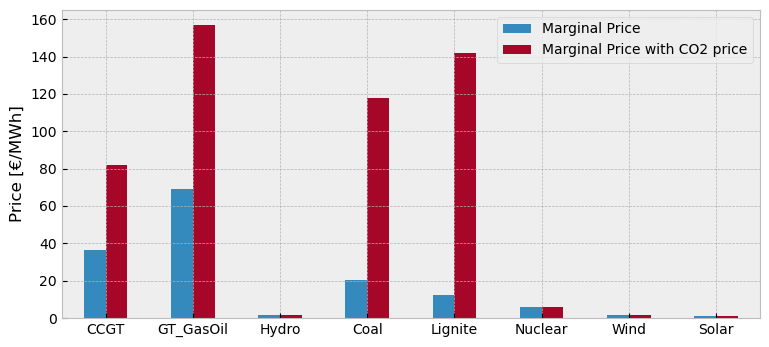

In [143]:
plt.style.use('bmh')
ax = marginal_price.plot.bar(figsize=(9,4),ylabel = 'Price [€/MWh]',xlabel='',rot=0)
ax.figure.savefig('marginal_price.pdf',bbox_inches='tight')